# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
#samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [8]:
df_krx = fdr.StockListing("KRX")

df_krx.head(10)

len(df_krx)

tiker_list = df_krx[['Symbol','Name']]
print(tiker_list)

      Symbol             Name
0     060310               3S
1     095570           AJ네트웍스
2     006840            AK홀딩스
3     054620           APS홀딩스
4     265520            AP시스템
...      ...              ...
7617  003280             흥아해운
7618  037440               희림
7619  419890  히어로즈 단기채권ESG액티브
7620  429870    히어로즈 리츠이지스액티브
7621  238490               힘스

[7622 rows x 2 columns]


In [9]:
print("\n원하는 종목을 입력하시오")
a = input()

Stock_Name = tiker_list.loc[tiker_list['Name'] == a]
print(Stock_Name,"\n")

symbol_Number = Stock_Name.Symbol

sn = symbol_Number.iloc[0]
print(sn)

Stock = fdr.DataReader(sn)


원하는 종목을 입력하시오
      Symbol Name
7621  238490   힘스 

238490


In [10]:
Stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-06-09,8000,8000,7800,7900,9167,-0.011264
2022-06-10,7790,7900,7760,7760,10358,-0.017722
2022-06-13,7570,7600,7470,7470,15394,-0.037371
2022-06-14,7460,7460,7020,7130,21767,-0.045515
2022-06-15,6940,7120,6840,6840,22115,-0.040673


## 시각화

Text(0, 0.5, 'price')

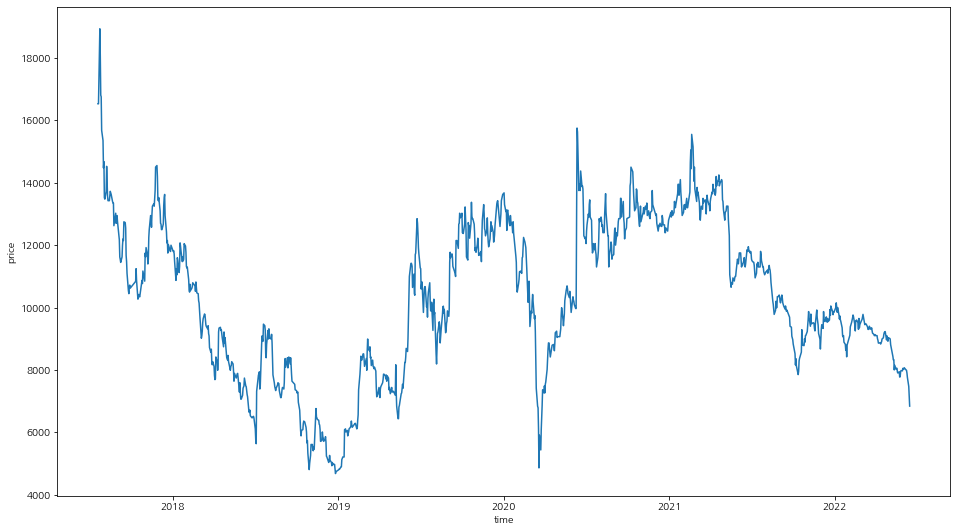

In [11]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=Stock['Close'], x=Stock.index)
plt.xlabel('time')
plt.ylabel('price')

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(Stock[scale_cols])
scaled

array([[0.79731553, 0.81493699, 0.79189646, 0.83136925, 0.80546109],
       [0.78038581, 0.80174177, 0.81954555, 0.83136925, 0.22438414],
       [0.87670309, 0.99175299, 0.94661372, 1.        , 0.61515718],
       ...,
       [0.20990152, 0.1828858 , 0.22148687, 0.19584736, 0.00354646],
       [0.20248213, 0.17364914, 0.18839621, 0.17199776, 0.00531871],
       [0.16740861, 0.15121726, 0.17515994, 0.15165544, 0.00541548]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [13]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [16]:
x_train.shape, y_train.shape

((963, 4), (963,))

In [17]:
x_test.shape, y_test.shape

((241, 4), (241,))

In [18]:
x_train

,Open,High,Low,Volume
0,0.797316,0.814937,0.791896,0.805461
1,0.780386,0.801742,0.819546,0.224384
2,0.876703,0.991753,0.946614,0.615157
3,1.000000,1.000000,1.000000,0.201983
4,0.898624,0.866200,0.856313,0.164779
...,...,...,...,...
958,0.485094,0.450089,0.510479,0.011244
959,0.464859,0.436894,0.495772,0.016223
960,0.461487,0.436894,0.503125,0.014326
961,0.468231,0.476480,0.503125,0.083399


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [19]:
import tensorflow as tf

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [21]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [22]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

2022-06-15 16:54:28.905236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 16:54:29.004610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 16:54:29.004787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 16:54:29.006632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [25]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [26]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [36]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     16/Unknown - 0s 3ms/step - loss: 5.1610e-04 - mse: 0.0010     
Epoch 1: val_loss did not improve from 0.00010
30/30 [==============================] - 0s 6ms/step - loss: 5.4320e-04 - mse: 0.0011 - val_loss: 1.0431e-04 - val_mse: 2.0861e-04
Epoch 2/100
16/30 [===============>..............] - ETA: 0s - loss: 5.5772e-04 - mse: 0.0011    
Epoch 2: val_loss did not improve from 0.00010
30/30 [==============================] - 0s 4ms/step - loss: 5.2558e-04 - mse: 0.0011 - val_loss: 2.5011e-04 - val_mse: 5.0021e-04
Epoch 3/100
19/30 [==================>...........] - ETA: 0s - loss: 5.5949e-04 - mse: 0.0011    
Epoch 3: val_loss did not improve from 0.00010
30/30 [==============================] - 0s 4ms/step - loss: 5.3033e-04 - mse: 0.0011 - val_loss: 2.3087e-04 - val_mse: 4.6174e-04
Epoch 4/100
22/30 [=====================>........] - ETA: 0s - loss: 5.5502e-04 - mse: 0.0011    
Epoch 4: val_loss did not improve from 0.00010
30/30 [==============================] - 0s 3

저장한 ModelCheckpoint 를 로드합니다.

In [37]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [38]:
pred = model.predict(test_data)

7/7 [==============================] - 0s 4ms/step


In [59]:
sliced_pred = pred[-61:]

fluctuation_len = len(sliced_pred)
fluctuation_len

61

In [70]:
fluctuation_arr = np.zeros(shape = (fluctuation_len) -1)

for i in range(61):
    if (i == 0) :
        continue
    else :
        pre_stock_price = sliced_pred[i - 1]
        cur_stock_price = sliced_pred[i]
        fluctuation_arr[i-1] = (cur_stock_price - pre_stock_price) / pre_stock_price * 100

In [71]:
fluctuation_arr

array([ 1.47041440e+00, -4.84112371e-03, -8.43142450e-01,  1.54891655e-01,
       -6.69667423e-01, -1.63846207e+00, -1.54153073e+00, -1.02040112e+00,
       -2.22631499e-01,  4.94782776e-01,  5.88067211e-02, -1.91683382e-01,
       -1.38845468e+00, -1.71161354e+00, -1.87488651e+00, -9.38292325e-01,
        1.78220987e-01, -2.12718964e-01,  3.87077838e-01,  6.92665040e-01,
        1.53192341e+00,  1.49219489e+00,  1.89778566e+00,  1.80627382e+00,
        8.89039755e-01,  2.46564552e-01, -3.38622189e+00, -1.23317146e+00,
        1.51967313e-02, -1.35387886e+00,  4.22465563e-01,  5.59304595e-01,
        1.87296756e-02, -2.55713844e+00, -4.13979340e+00, -5.20910549e+00,
       -4.36818027e+00, -1.21104956e+00, -4.52123117e+00, -1.30699277e+00,
       -8.67999256e-01, -3.56602341e-01,  3.29981267e-01, -1.97879350e+00,
       -1.98187125e+00, -2.57814378e-01, -2.18328404e+00, -1.84322667e+00,
        2.28644991e+00,  3.14537811e+00,  1.19754565e+00,  1.00715601e+00,
        2.14150831e-01,  

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

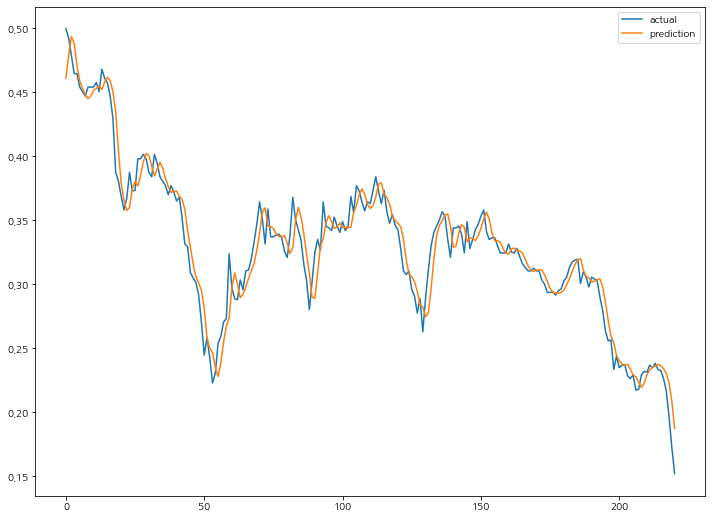

In [31]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

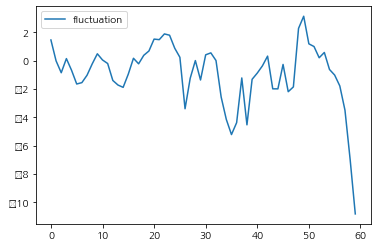

In [73]:
plt.plot(fluctuation_arr, label='fluctuation')
plt.legend()
plt.show()